In [2]:
import pandas as pd
import numpy as np
import time
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import (f1_score, classification_report, confusion_matrix,
                           precision_recall_curve, auc, make_scorer)
import joblib
import warnings
import sys
import shap

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("Libraries imported successfully!\n")

Libraries imported successfully!



In [3]:
def plot_failure_distribution(df, target_col, show_plots):
    """Plots a pie chart of the target variable distribution."""
    if not show_plots: return
    print("Plotting target variable distribution...")
    counts = df[target_col].value_counts()
    fig = px.pie(values=counts.values,
                 names=['0: No Failure', '1: Failure'],
                 title='Target Variable: Machine Failure Class Distribution',
                 color_discrete_sequence=['#1f77b4', '#d62728'],
                 hole=0.3)
    fig.update_traces(textinfo='percent+label', pull=[0, 0.1])
    fig.show()

In [4]:
def plot_sensor_boxplots(df, sensor_cols, target_col, show_plots):
    """Plots boxplots for sensors vs. failure."""
    if not show_plots: return
    print("Plotting sensor distributions vs. failure...")
    fig = make_subplots(rows=len(sensor_cols), cols=1, subplot_titles=sensor_cols)
    for i, col in enumerate(sensor_cols):
        fig.add_trace(go.Box(x=df[df[target_col]==0][col], name='0: No Failure', marker_color='#1f77b4'), row=i+1, col=1)
        fig.add_trace(go.Box(x=df[df[target_col]==1][col], name='1: Failure', marker_color='#d62728'), row=i+1, col=1)
    fig.update_layout(height=1200, width=900, title_text="Sensor Distributions: Failure (1) vs. No Failure (0)", showlegend=False)
    fig.show()

In [5]:
def plot_correlation_heatmap(df, show_plots):
    """Plots a correlation heatmap of numeric features."""
    if not show_plots: return
    print("Plotting correlation heatmap...")
    df_numeric = df.select_dtypes(include=np.number).drop(columns=['UDI'], errors='ignore')
    corr = df_numeric.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap of Numerical Features')
    plt.show()

In [6]:
def plot_interactive_scatter(df, x_col, y_col, target_col, show_plots):
    """Plots an interactive scatter plot, colored by failure."""
    if not show_plots: return
    print(f"Plotting interactive scatter: {x_col} vs {y_col}...")
    fig = px.scatter(df.sample(n=2000, replace=False, random_state=42),  # Sample for performance
                     x=x_col,
                     y=y_col,
                     color=target_col,
                     title=f'{x_col} vs. {y_col} (Colored by Machine Failure)',
                     color_continuous_scale='Bluered_r')
    fig.show()

In [7]:
def plot_engineered_feature_kde(df, feature_col, target_col, show_plots):
    """Plots a KDE of an engineered feature vs. failure."""
    if not show_plots: return
    print(f"Plotting distribution of engineered feature: {feature_col}...")
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df[df[target_col] == 0][feature_col], label='0: No Failure', shade=True)
    sns.kdeplot(df[df[target_col] == 1][feature_col], label='1: Failure', shade=True)
    plt.title(f'Distribution of "{feature_col}" by Machine Failure')
    plt.legend()
    plt.show()

In [8]:
def plot_confusion_matrix_heatmap(cm, title, show_plots):
    """Plots a heatmap for the confusion matrix."""
    if not show_plots: return
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [9]:
def plot_pr_curve(y_test, y_pred_proba, model_name, show_plots):
    """Plots the Precision-Recall curve."""
    if not show_plots: return
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', label=f'PR Curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend()
    plt.show()

In [10]:
def plot_feature_importances(importances, features, title, show_plots):
    """Plots the top 20 feature importances."""
    if not show_plots: return
    feature_importance_df = pd.DataFrame({
        'feature': features,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(20)

    print(f"\nTop 20 Most Important Features ({title}):\n")
    print(feature_importance_df)

    fig = px.bar(feature_importance_df,
                     x='importance',
                     y='feature',
                     orientation='h',
                     title=f'Top 20 Feature Importances - {title}')
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    fig.show()

In [11]:
def plot_model_comparison(results, title, show_plots):
    """Plots a bar chart comparing model F1 scores."""
    if not show_plots: return
    df_results = pd.DataFrame(list(results.items()), columns=['Model', 'F1 Score'])
    fig = px.bar(df_results, x='Model', y='F1 Score',
                 title=title, color='Model', text_auto='.4f')
    fig.show()

In [12]:
def run_maintenance_pipeline():

    SHOW_PLOTS = True

    start_time = time.time()

    print("--- 2. Loading Data ---")
    try:
        df = pd.read_csv('ai4i2020.csv')
        print("Loaded data from local 'ai4i2020.csv'\n")
    except FileNotFoundError:
        print("Error: 'ai4i2020.csv' not found locally.")
        url = 'https://raw.githubusercontent.com/gokul-data-analytics/Predictive-Maintenance-Modelling/main/ai4i2020.csv'
        print(f"Attempting to load from {url}...")
        try:
            df = pd.read_csv(url)
            print("Loaded data from URL.\n")
        except Exception as e:
            print(f"Could not load from URL: {e}. Exiting.")
            return

    print(f"Dataset Shape: {df.shape}")
    print("\n--- Data Info ---")
    df.info()

    print("\n" + "="*50)
    print("--- 3. Exploratory Data Analysis (EDA) ---")
    print("="*50 + "\n")

    target_col = 'Machine failure'
    sensor_cols = ['Air temperature [K]', 'Process temperature [K]',
                   'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

    plot_failure_distribution(df, target_col, SHOW_PLOTS)
    plot_sensor_boxplots(df, sensor_cols, target_col, SHOW_PLOTS)
    plot_correlation_heatmap(df, SHOW_PLOTS)

    plot_interactive_scatter(df, 'Torque [Nm]', 'Rotational speed [rpm]', target_col, SHOW_PLOTS)

    print("\nKey EDA Insights:")
    print("* Target is *highly* imbalanced (~3.4% failures).")
    print("* Torque & Rotational Speed show the clearest separation between failure/no failure.")
    print("* `power` (Torque * Speed) and `temp_diff` will be strong features.")

    print("\n" + "="*50)
    print("--- 4. Advanced Feature Engineering ---")
    print("="*50 + "\n")

    df_feat = df.copy()

    df_feat['power'] = df_feat['Torque [Nm]'] * df_feat['Rotational speed [rpm]']
    df_feat['temp_diff'] = df_feat['Process temperature [K]'] - df_feat['Air temperature [K]']
    df_feat['strain'] = df_feat['Torque [Nm]'] * df_feat['Tool wear [min]']

    window_sizes = [5, 10, 20]
    lag_periods = [1, 2, 3]

    rolling_cols = sensor_cols + ['power', 'temp_diff', 'strain']

    for col in rolling_cols:
        print(f"Engineering features for: {col}")

        for lag in lag_periods:
            df_feat[f'{col}_lag_{lag}'] = df_feat[col].shift(lag)

        df_feat[f'{col}_diff_1'] = df_feat[col].diff(1)

        for w in window_sizes:
            rolling_window = df_feat[col].rolling(window=w)
            df_feat[f'{col}_roll_mean_{w}'] = rolling_window.mean()
            df_feat[f'{col}_roll_std_{w}'] = rolling_window.std()
            df_feat[f'{col}_roll_min_{w}'] = rolling_window.min()
            df_feat[f'{col}_roll_max_{w}'] = rolling_window.max()

    df_feat['tool_wear_cumsum'] = df_feat['Tool wear [min]'].cumsum()

    df_feat['torque_per_wear'] = df_feat['Torque [Nm]'] / (df_feat['Tool wear [min]'] + 1e-6)

    print(f"\nOriginal feature count: {len(df.columns)}")
    print(f"New feature count: {len(df_feat.columns)}")

    print(f"\nShape before dropping NaNs: {df_feat.shape}")
    df_model = df_feat.dropna()
    print(f"Shape after dropping NaNs: {df_model.shape}\n")

    plot_engineered_feature_kde(df_model, 'power', target_col, SHOW_PLOTS)

    print("\n" + "="*50)
    print("--- 5. Data Preprocessing ---")
    print("="*50 + "\n")

    y = df_model['Machine failure']


    X = df_model.drop(columns=['UDI', 'Product ID', 'Machine failure',
                                'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])

    X = pd.get_dummies(X, columns=['Type'], drop_first=True)

    feature_names = X.columns.to_list()
    print(f"Final feature count for modeling: {len(feature_names)}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    print(f"Train X shape: {X_train.shape}, Test X shape: {X_test.shape}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("\nData split and scaled successfully.")

    print("\n" + "="*50)
    print("--- 6. Applying SMOTE to Training Data ---")
    print("="*50 + "\n")
    print(f"Original training labels: \n{y_train.value_counts()}")

    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

    print("\n--- After SMOTE --- ")
    print(f"Resampled training shape: {X_train_res.shape}")
    print(f"Resampled training labels: \n{pd.Series(y_train_res).value_counts()}")
    print("\nSMOTE applied successfully. Training data is now balanced.")

    print("\n" + "="*50)
    print("--- 7. Model 1: RandomForest + Tuning ---")
    print("="*50 + "\n")

    param_dist_rf = {
        'n_estimators': [100, 150, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    f1_scorer = make_scorer(f1_score, pos_label=1)


    rf_search = RandomizedSearchCV(
        estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
        param_distributions=param_dist_rf,
        n_iter=10,  # Reduced from 25
        cv=2,       # Reduced from 3
        scoring=f1_scorer,
        random_state=42,
        verbose=1  # Show progress
    )

    print("Starting RandomizedSearchCV for RandomForest...")
    search_start_time = time.time()
    rf_search.fit(X_train_res, y_train_res)
    print(f"Tuning finished in {time.time() - search_start_time:.2f} seconds.")

    print(f"\nBest parameters found: {rf_search.best_params_}")
    print(f"Best F1-score during tuning: {rf_search.best_score_:.4f}")

    rf_model_best = rf_search.best_estimator_

    print("\n--- Tuned RandomForest Evaluation ---")
    y_pred_rf = rf_model_best.predict(X_test_scaled)
    y_pred_proba_rf = rf_model_best.predict_proba(X_test_scaled)[:, 1]

    f1_rf = f1_score(y_test, y_pred_rf, pos_label=1)
    print("=============================================")
    print(f"Tuned RF F1-SCORE (class 1): {f1_rf:.4f}")
    print("=============================================\n")
    print("Classification Report:\n", classification_report(y_test, y_pred_rf))

    cm_rf = confusion_matrix(y_test, y_pred_rf)
    plot_confusion_matrix_heatmap(cm_rf, "Confusion Matrix - Tuned RandomForest", SHOW_PLOTS)
    plot_pr_curve(y_test, y_pred_proba_rf, "Tuned RandomForest", SHOW_PLOTS)

    print("\n" + "="*50)
    print("--- 8. Feature Importance (Tuned RF) ---")
    print("="*50 + "\n")
    plot_feature_importances(rf_model_best.feature_importances_,
                               feature_names, "Tuned RandomForest", SHOW_PLOTS)
    print("\n*Insight: Note how many 'roll' and 'diff' features are at the top!*")

    print("\n" + "="*50)
    print("--- 9. Model 2: XGBoost + Tuning ---")
    print("="*50 + "\n")
    print("Training XGBoostClassifier for comparison...")

    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )

    param_dist_xgb = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2]
    }

    xgb_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist_xgb,
        n_iter=10,   # Reduced from 25
        cv=2,        # Reduced from 3
        scoring=f1_scorer,
        random_state=42,
        verbose=1,
        n_jobs=-1
    )

    print("Starting RandomizedSearchCV for XGBoost...")
    search_start_time = time.time()
    xgb_search.fit(X_train_res, y_train_res)
    print(f"Tuning finished in {time.time() - search_start_time:.2f} seconds.")

    print(f"\nBest parameters found: {xgb_search.best_params_}")
    print(f"Best F1-score during tuning: {xgb_search.best_score_:.4f}")

    xgb_model_best = xgb_search.best_estimator_

    print("\n--- Tuned XGBoost Evaluation ---")
    y_pred_xgb = xgb_model_best.predict(X_test_scaled)
    y_pred_proba_xgb = xgb_model_best.predict_proba(X_test_scaled)[:, 1]

    f1_xgb = f1_score(y_test, y_pred_xgb, pos_label=1)
    print("=============================================")
    print(f"Tuned XGBoost F1-SCORE (class 1): {f1_xgb:.4f}")
    print("=============================================\n")
    print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

    cm_xgb = confusion_matrix(y_test, y_pred_xgb)
    plot_confusion_matrix_heatmap(cm_xgb, "Confusion Matrix - Tuned XGBoost", SHOW_PLOTS)
    plot_pr_curve(y_test, y_pred_proba_xgb, "Tuned XGBoost", SHOW_PLOTS)


    print("\n" + "="*50)
    print("--- 10. Model 3: LightGBM + Tuning ---")
    print("="*50 + "\n")
    print("Training LightGBM Classifier...")

    lgb_model = lgb.LGBMClassifier(
        objective='binary',
        metric='f1',
        random_state=42,
        n_jobs=-1
    )

    param_dist_lgb = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 20, -1],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }

    lgb_search = RandomizedSearchCV(
        estimator=lgb_model,
        param_distributions=param_dist_lgb,
        n_iter=10,   # Reduced from 25
        cv=2,        # Reduced from 3
        scoring=f1_scorer,
        random_state=42,
        verbose=1,
        n_jobs=-1
    )

    print("Starting RandomizedSearchCV for LightGBM...")
    search_start_time = time.time()
    lgb_search.fit(X_train_res, y_train_res)
    print(f"Tuning finished in {time.time() - search_start_time:.2f} seconds.")

    print(f"\nBest parameters found: {lgb_search.best_params_}")
    print(f"Best F1-score during tuning: {lgb_search.best_score_:.4f}")

    lgb_model_best = lgb_search.best_estimator_

    print("\n--- Tuned LightGBM Evaluation ---")
    y_pred_lgb = lgb_model_best.predict(X_test_scaled)
    y_pred_proba_lgb = lgb_model_best.predict_proba(X_test_scaled)[:, 1]

    f1_lgb = f1_score(y_test, y_pred_lgb, pos_label=1)
    print("=============================================")
    print(f"Tuned LightGBM F1-SCORE (class 1): {f1_lgb:.4f}")
    print("=============================================\n")
    print("Classification Report:\n", classification_report(y_test, y_pred_lgb))

    cm_lgb = confusion_matrix(y_test, y_pred_lgb)
    plot_confusion_matrix_heatmap(cm_lgb, "Confusion Matrix - Tuned LightGBM", SHOW_PLOTS)
    plot_pr_curve(y_test, y_pred_proba_lgb, "Tuned LightGBM", SHOW_PLOTS)


    print("\n" + "="*50)
    print("--- 11. Ensemble Model: Voting Classifier ---")
    print("="*50 + "\n")
    print("Combining best models into a soft-voting ensemble...")

    estimators = [
        ('rf', rf_model_best),
        ('xgb', xgb_model_best),
        ('lgb', lgb_model_best)
    ]

    voting_model = VotingClassifier(
        estimators=estimators,
        voting='soft',
        n_jobs=-1
    )

    print("Fitting ensemble model...")
    voting_model.fit(X_train_res, y_train_res)

    print("\n--- Ensemble Model Evaluation ---")
    y_pred_vote = voting_model.predict(X_test_scaled)
    y_pred_proba_vote = voting_model.predict_proba(X_test_scaled)[:, 1]

    f1_vote = f1_score(y_test, y_pred_vote, pos_label=1)
    print("=============================================")
    print(f"Ensemble Model F1-SCORE (class 1): {f1_vote:.4f}")
    print("=============================================\n")
    print("Classification Report:\n", classification_report(y_test, y_pred_vote))

    cm_vote = confusion_matrix(y_test, y_pred_vote)
    plot_confusion_matrix_heatmap(cm_vote, "Confusion Matrix - Ensemble Model", SHOW_PLOTS)
    plot_pr_curve(y_test, y_pred_proba_vote, "Ensemble Model", SHOW_PLOTS)


    print("\n" + "="*50)
    print("--- 12. Final Comparison & Model Saving ---")
    print("="*50 + "\n")

    model_results = {
        'Tuned RandomForest': f1_rf,
        'Tuned XGBoost': f1_xgb,
        'Tuned LightGBM': f1_lgb,
        'Ensemble (Voting)': f1_vote
    }

    all_models = {
        'Tuned RandomForest': rf_model_best,
        'Tuned XGBoost': xgb_model_best,
        'Tuned LightGBM': lgb_model_best,
        'Ensemble (Voting)': voting_model
    }

    plot_model_comparison(model_results, "Final Model F1 Score Comparison", SHOW_PLOTS)

    best_model_name = max(model_results, key=model_results.get)
    best_model_to_save = all_models[best_model_name]
    best_f1_score = model_results[best_model_name]

    model_filename = 'predictive_maintenance_model.joblib'
    scaler_filename = 'data_scaler.joblib'

    print(f"\nBest model: {best_model_name} (F1 Score: {best_f1_score:.4f})")
    print(f"Saving {best_model_name} to {model_filename}")
    joblib.dump(best_model_to_save, model_filename)

    print(f"Saving scaler to {scaler_filename}")
    joblib.dump(scaler, scaler_filename)

    print("\nModel and scaler saved successfully.")
    print("To load them later:")
    print(f"  model = joblib.load('{model_filename}')")
    print(f"  scaler = joblib.load('{scaler_filename}')")

--- 2. Loading Data ---
Loaded data from local 'ai4i2020.csv'

Dataset Shape: (10000, 14)

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                   

Plotting sensor distributions vs. failure...


Plotting correlation heatmap...


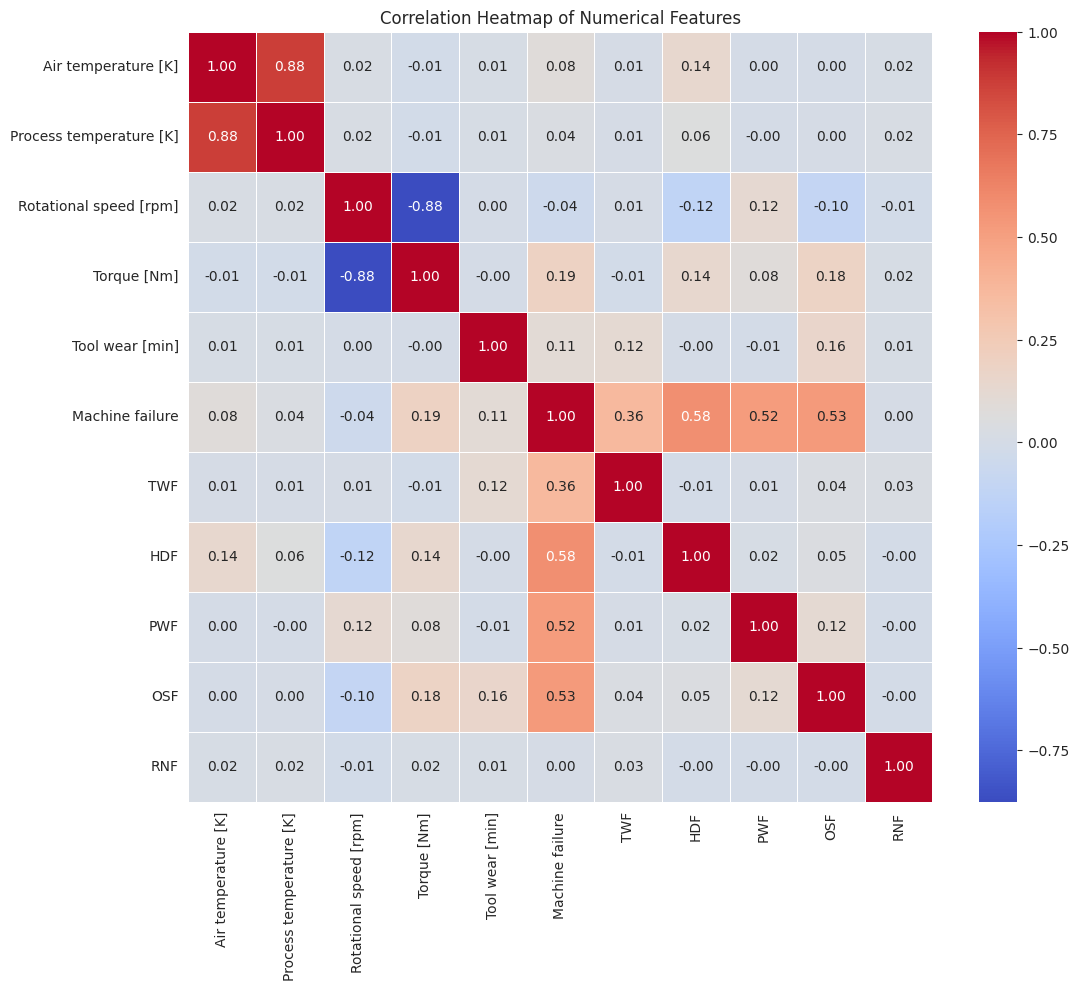

Plotting interactive scatter: Torque [Nm] vs Rotational speed [rpm]...



Key EDA Insights:
* Target is *highly* imbalanced (~3.4% failures).
* Torque & Rotational Speed show the clearest separation between failure/no failure.
* `power` (Torque * Speed) and `temp_diff` will be strong features.

--- 4. Advanced Feature Engineering ---

Engineering features for: Air temperature [K]
Engineering features for: Process temperature [K]
Engineering features for: Rotational speed [rpm]
Engineering features for: Torque [Nm]
Engineering features for: Tool wear [min]
Engineering features for: power
Engineering features for: temp_diff
Engineering features for: strain

Original feature count: 14
New feature count: 147

Shape before dropping NaNs: (10000, 147)
Shape after dropping NaNs: (9981, 147)

Plotting distribution of engineered feature: power...


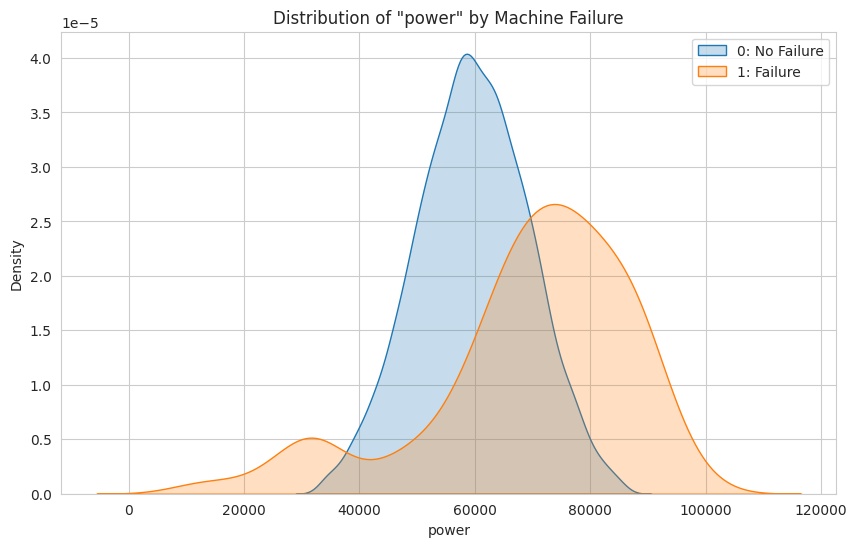


--- 5. Data Preprocessing ---

Final feature count for modeling: 140
Train X shape: (7984, 140), Test X shape: (1997, 140)

Data split and scaled successfully.

--- 6. Applying SMOTE to Training Data ---

Original training labels: 
Machine failure
0    7713
1     271
Name: count, dtype: int64

--- After SMOTE --- 
Resampled training shape: (15426, 140)
Resampled training labels: 
Machine failure
0    7713
1    7713
Name: count, dtype: int64

SMOTE applied successfully. Training data is now balanced.

--- 7. Model 1: RandomForest + Tuning ---

Starting RandomizedSearchCV for RandomForest...
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tuning finished in 813.91 seconds.

Best parameters found: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Best F1-score during tuning: 0.9857

--- Tuned RandomForest Evaluation ---
Tuned RF F1-SCORE (class 1): 0.7231

Classification Report:
               precision    recall  f

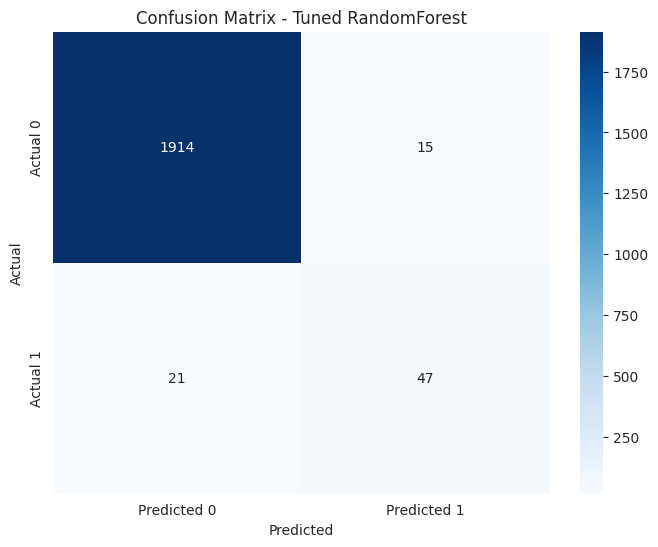

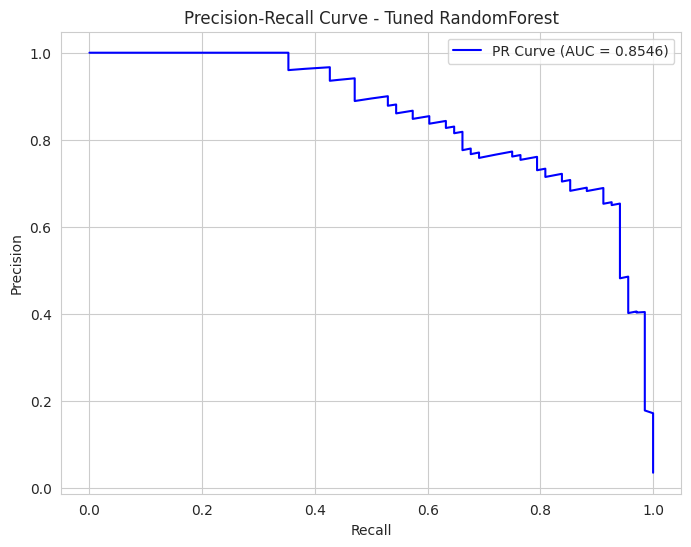


--- 8. Feature Importance (Tuned RF) ---


Top 20 Most Important Features (Tuned RandomForest):

                           feature  importance
3                      Torque [Nm]    0.056236
5                            power    0.048007
2           Rotational speed [rpm]    0.047523
7                           strain    0.025802
123                  strain_diff_1    0.023758
43   Rotational speed [rpm]_diff_1    0.022325
86     Tool wear [min]_roll_min_20    0.021700
59              Torque [Nm]_diff_1    0.019652
127              strain_roll_max_5    0.018076
93                power_roll_std_5    0.017346
82     Tool wear [min]_roll_min_10    0.017332
4                  Tool wear [min]    0.017261
63          Torque [Nm]_roll_max_5    0.016366
91                    power_diff_1    0.016048
118          temp_diff_roll_min_20    0.015056
95                power_roll_max_5    0.014733
131             strain_roll_max_10    0.014349
105                temp_diff_lag_2    0.012920
114      


*Insight: Note how many 'roll' and 'diff' features are at the top!*

--- 9. Model 2: XGBoost + Tuning ---

Training XGBoostClassifier for comparison...
Starting RandomizedSearchCV for XGBoost...
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tuning finished in 94.08 seconds.

Best parameters found: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
Best F1-score during tuning: 0.9937

--- Tuned XGBoost Evaluation ---
Tuned XGBoost F1-SCORE (class 1): 0.9091

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1929
           1       0.94      0.88      0.91        68

    accuracy                           0.99      1997
   macro avg       0.97      0.94      0.95      1997
weighted avg       0.99      0.99      0.99      1997



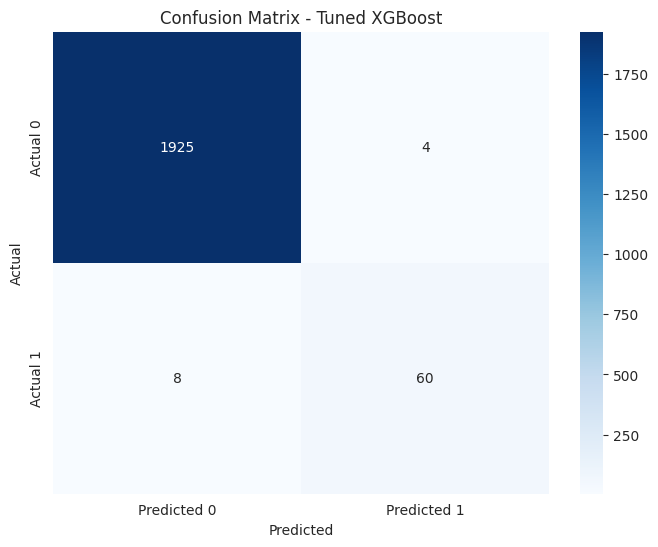

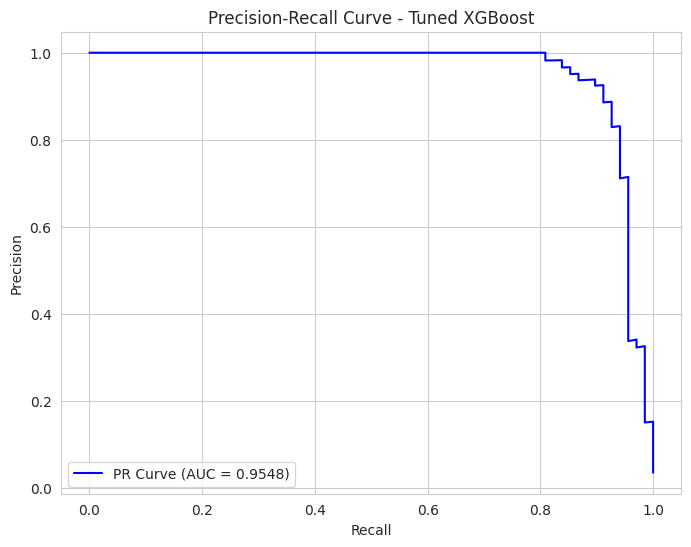


--- 10. Model 3: LightGBM + Tuning ---

Training LightGBM Classifier...
Starting RandomizedSearchCV for LightGBM...
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 7713, number of negative: 7713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35681
[LightGBM] [Info] Number of data points in the train set: 15426, number of used features: 140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

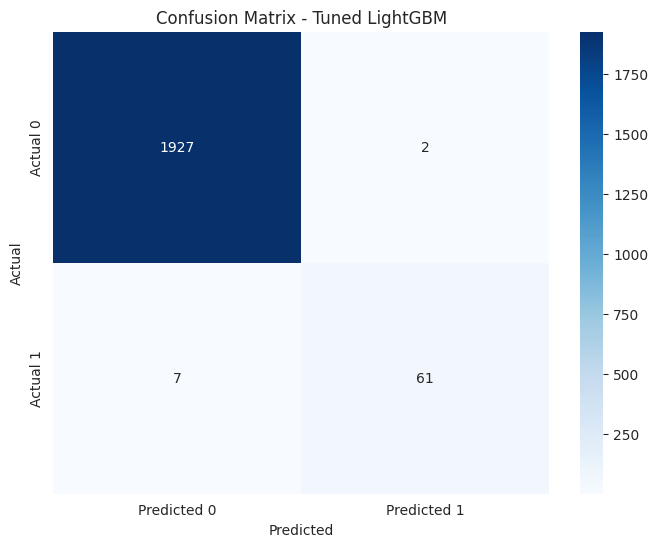

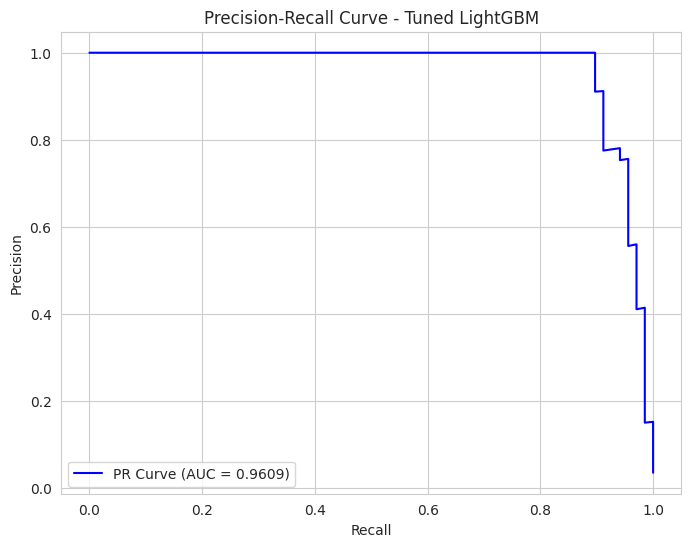


--- 11. Ensemble Model: Voting Classifier ---

Combining best models into a soft-voting ensemble...
Fitting ensemble model...

--- Ensemble Model Evaluation ---
Ensemble Model F1-SCORE (class 1): 0.9242

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1929
           1       0.95      0.90      0.92        68

    accuracy                           0.99      1997
   macro avg       0.97      0.95      0.96      1997
weighted avg       0.99      0.99      0.99      1997



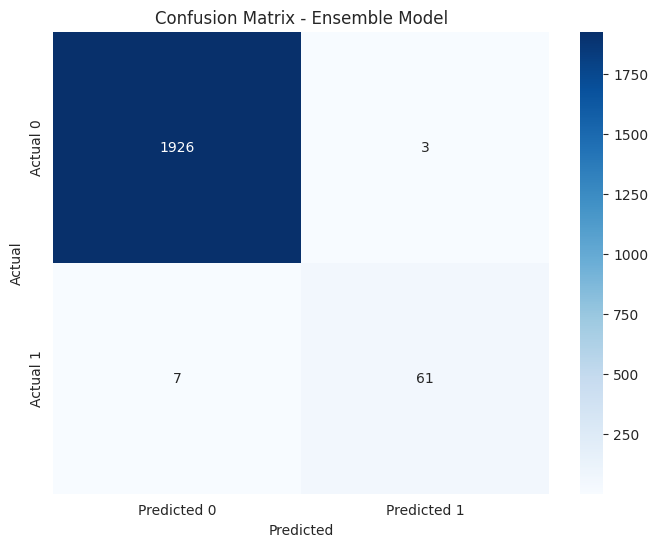

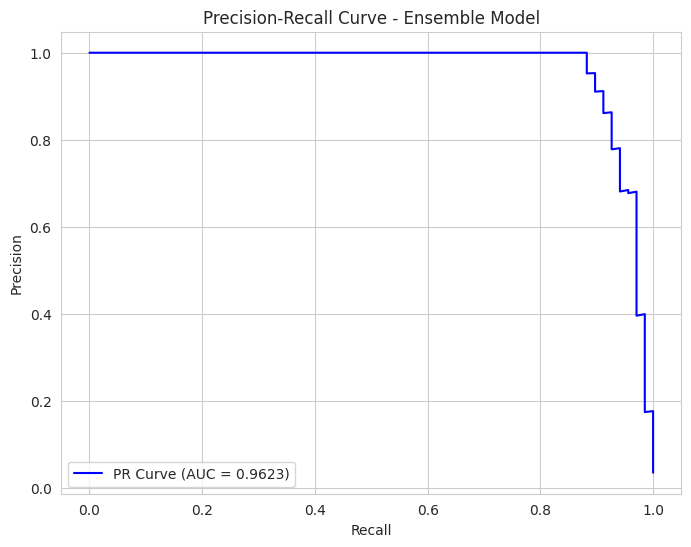


--- 12. Final Comparison & Model Saving ---




Best model: Tuned LightGBM (F1 Score: 0.9313)
Saving Tuned LightGBM to predictive_maintenance_model.joblib
Saving scaler to data_scaler.joblib

Model and scaler saved successfully.
To load them later:
  model = joblib.load('predictive_maintenance_model.joblib')
  scaler = joblib.load('data_scaler.joblib')


In [16]:
if __name__ == "__main__":
    run_maintenance_pipeline()

In [17]:
model = joblib.load('predictive_maintenance_model.joblib')
scaler = joblib.load('data_scaler.joblib')

In [18]:
model

LGBMClassifier(colsample_bytree=0.8, max_depth=10, metric='f1',
               n_estimators=300, n_jobs=-1, num_leaves=100, objective='binary',
               random_state=42)

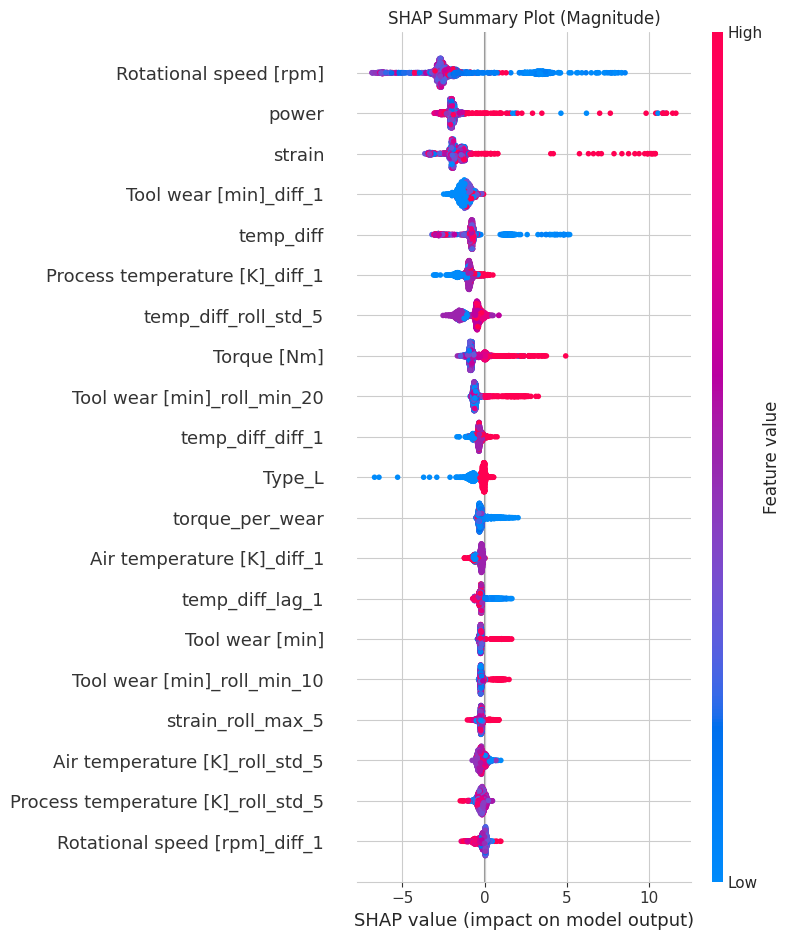

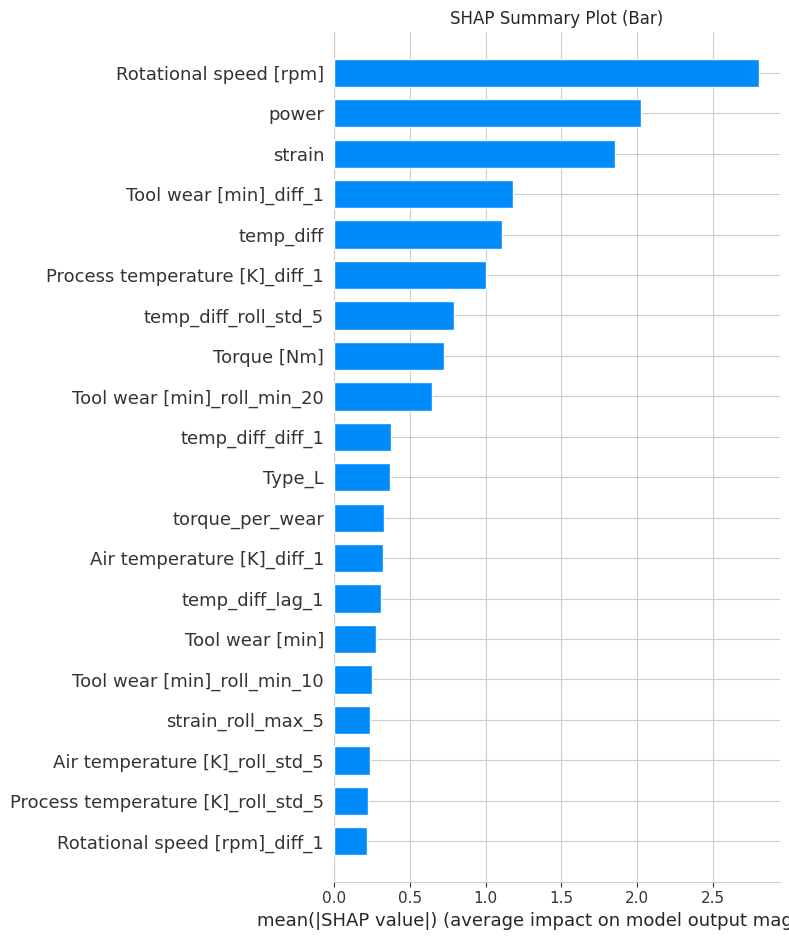

SHAP plots generated: shap_summary_magnitude.png, shap_summary_bar.png, shap_force_plot.html


In [21]:
# Create an explainer for your trained LightGBM model
# The previous error was 'your_lgb_model' not defined. It should be 'model'.
explainer = shap.TreeExplainer(model)

# Re-create the necessary data for SHAP analysis: X_test and feature_names
# This section replicates the preprocessing steps from the run_maintenance_pipeline function.

# Load data
df = pd.read_csv('ai4i2020.csv')

# Feature Engineering
df_feat = df.copy()
df_feat['power'] = df_feat['Torque [Nm]'] * df_feat['Rotational speed [rpm]']
df_feat['temp_diff'] = df_feat['Process temperature [K]'] - df_feat['Air temperature [K]']
df_feat['strain'] = df_feat['Torque [Nm]'] * df_feat['Tool wear [min]']

window_sizes = [5, 10, 20]
lag_periods = [1, 2, 3]

sensor_cols = ['Air temperature [K]', 'Process temperature [K]',
               'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
rolling_cols = sensor_cols + ['power', 'temp_diff', 'strain']

for col in rolling_cols:
    for lag in lag_periods:
        df_feat[f'{col}_lag_{lag}'] = df_feat[col].shift(lag)
    df_feat[f'{col}_diff_1'] = df_feat[col].diff(1)
    for w in window_sizes:
        rolling_window = df_feat[col].rolling(window=w)
        df_feat[f'{col}_roll_mean_{w}'] = rolling_window.mean()
        df_feat[f'{col}_roll_std_{w}'] = rolling_window.std()
        df_feat[f'{col}_roll_min_{w}'] = rolling_window.min()
        df_feat[f'{col}_roll_max_{w}'] = rolling_window.max()

df_feat['tool_wear_cumsum'] = df_feat['Tool wear [min]'].cumsum()
df_feat['torque_per_wear'] = df_feat['Torque [Nm]'] / (df_feat['Tool wear [min]'] + 1e-6)

# Data Preprocessing
df_model = df_feat.dropna()
y = df_model['Machine failure']
X = df_model.drop(columns=['UDI', 'Product ID', 'Machine failure',
                            'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
X = pd.get_dummies(X, columns=['Type'], drop_first=True)
feature_names = X.columns.to_list()

# Split data - crucial to get the same X_test as during training
# We only need X_test here for SHAP, y_train and y_test are not used directly by SHAP plotting functions.
_, X_test, _, _ = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Scale X_test using the loaded scaler
# 'scaler' was loaded globally in a previous cell
X_test_scaled_array = scaler.transform(X_test)
# Convert scaled array back to DataFrame for SHAP plots to retain feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled_array, columns=feature_names, index=X_test.index)


# Generate SHAP values
# For LightGBM (and other tree models), explainer.shap_values returns a list of arrays (one for each class).
# The kernel state shows 'shap_values' as an ndarray, implying it might have been assigned
# directly to the positive class SHAP values. We'll handle both cases.
raw_shap_values = explainer.shap_values(X_test_scaled_df)

# Determine the correct shap_values matrix for the positive class
if isinstance(raw_shap_values, list):
    # If it's a list, take the SHAP values for the positive class (index 1)
    shap_values_for_plot = raw_shap_values[1]
    expected_value_for_positive_class = explainer.expected_value[1]
else:
    # If it's already a single array, assume it's for the positive class
    shap_values_for_plot = raw_shap_values
    expected_value_for_positive_class = explainer.expected_value # It might be a single value then


# Plotting SHAP values
# The 'show=False' argument prevents immediate display in notebooks and allows saving.
shap.summary_plot(shap_values_for_plot, X_test_scaled_df, show=False)
plt.title("SHAP Summary Plot (Magnitude)")
plt.tight_layout()
plt.savefig("shap_summary_magnitude.png")
plt.show()

shap.summary_plot(shap_values_for_plot, X_test_scaled_df, plot_type="bar", show=False)
plt.title("SHAP Summary Plot (Bar)")
plt.tight_layout()
plt.savefig("shap_summary_bar.png")
plt.show()

# For force plot, use the first instance from the test set
force_plot_html = shap.force_plot(
    expected_value_for_positive_class,
    shap_values_for_plot[0,:],
    X_test_scaled_df.iloc[0,:],
    show=False # Prevent immediate display in notebook
)

# Save the force plot to an HTML file
shap.save_html("shap_force_plot.html", force_plot_html)
print("SHAP plots generated: shap_summary_magnitude.png, shap_summary_bar.png, shap_force_plot.html")

In [23]:

joblib.dump(model, "lightgbm_model.joblib")


['lightgbm_model.joblib']